# Can we design an algorithm to spot good data contributors on a Minecraft server?
## *DSCI100 Group Project Final Report*

**Group 004-008**

Atlas **Danks** **(59825927)**,
Isabelle **He** **(26923540)**,
Aisa **Rafiei** **(80157365)**,
Steven **Weng** **(95102919)**.

## Introduction

### Background Information and Research Aim

PLAI, the Pacific Laboratory for Artificial Intelligence, is a research lab at the University of British Columbia which is currently aiming to create artificially intelligent NPCs capable of playing the video game Minecraft. To accomplish this, they have created a custom server from which they can collect data on how players of Minecraft interact throughout the game’s world. 

One question that is relevant to their study is **which kinds of players are most likely to contribute the most data** to their research, something which could be measured by metrics such as the number of hours played. To answer this, our own research question was whether we could clearly define “good players” as a category from the data they have given us and create an algorithm that could accurately predict whether an individual player would contribute a significant amount.


To analyze this question, we used the `players.csv` file. This file lists all players who have signed up, as well as their `gender`, `age`, self-reported `experience` level, whether they have subscribed to the PLAIcraft email listing, as well as how many hours they have played. We also added `sessions` column from the `sessions.csv` data set.

### Data Description
The data is organized into two datasets, `players.csv` and `sessions.csv`, containing data on individual players and their individual sessions respectively. 

**Players data**

The players dataset has **196 observations**, corresponding to 196 players, and **9 variables**: 
* `experience (fct)`: The player’s self-reported experience level in minecraft from a list of five categories. The most popular experience category was “Amateur”. The next most popular category was “Veteran”.


* `subscribe (lgl)`: Whether the player has subscribed to PLAIcraft email updates. 

* `hashedEmail (chr)`: An anonymized version of the player’s email code. This variable is shared with the sessions.csv data, so in spite of anonymity it is possible to get a full picture of each individual’s playing history. 


* `played_hours (dbl)`: The number of hours each individual has played on the server. 

* `name (chr)`: A nickname chosen by each player from a randomized list upon account creation. 


* `gender (fct)`: The player’s reported gender. 

* `age (int)`: The player’s reported age. 

There are two additional variables, that being `individualId` and `organizationName`. These variables have no data, and appear to have been wiped blank for player privacy. 

**Sessions data**

The `sessions.csv` dataset has **1535 observations**, each of which comprises a single play session by a player. This file contains **5 variables**, them being:
* `hashedEmail (chr)`: an anonymized hash code of the player’s email. Shared with `players.csv`.


* `start_time (dttm)`: The date and time of the beginning of the player’s session.


* `end_time (dttm)`: The date and time of the end of the player’s session.


* `original_start_time (dbl)`: the start time encoded into Unix time. 


* `original_end_time (dbl)`: the end time encoded into Unix time. 


In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(themis)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Data Wrangling and Tidying

**Combining datasets**:

For this project, we first combined our two files into one document in order to get an accurate picture of how many `sessions` each player played on the server. To do this, we first summarized the session data in `sessions.csv` to get a total amount of sessions per player, and then combined it with the `players.csv` data through checking the hashed email codes shared by the two files.

**Removing suspicious data**:

Finally, we removed any data from our file that seemed suspicious or unusual, in order to make sure any inaccurate samples did not skew our whole. Luckily, except for a small handful of suspicious answers for the `age` category, there was little that needed to be filtered out (> 90).

In [2]:
#Reading in data and basic tidying

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(players_url)

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(sessions_url)

sessions_per_player <- sessions_data |>
group_by(hashedEmail) |>
summarize(sessions = n()) |>
arrange(-sessions) 

combined_data <- left_join(players_data, sessions_per_player, by = "hashedEmail")

modified_data <- combined_data |>
  mutate(gender = as_factor(gender))

clean_data <- modified_data |>
    select(- individualId, -organizationName) |>
    filter(age <90)
clean_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,sessions
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1


## Methods & Results

### Model Number 1: Exploring correlation between experience and played_hours with 0-hour players + upsampling all the training data

We would like to test if including players with zero played hours affects the accuracy of our model. In order to test how reliable `played_hours` is as a predictor when players with zero played hours are included, we will first create a model that uses all the `played_hours` info in our dataset.

Since the classification model is purely based on a numerical value, played hours, balancing the dataset would be needed in the training dataset since knn classification will place more importance on the experience with the highest player count. Balancing out the dataset will include splitting the data first, (75% training, 25% testing) and using the `step_upsample` function in the `recipe()`, `prep()` it, and bake it onto the training data.

In [3]:
set.seed(3456)
players0 <- players_data |> 
mutate(experience = as.factor(experience))

hours0_split <- initial_split(players0, prop = 0.75, strata = experience)
hours0_train <- training(hours0_split)
hours0_test <- testing(hours0_split)

summary(hours0_train$experience)

hours0_train <- recipe(experience ~ played_hours, data = hours0_train) |>
step_upsample(experience, over_ratio = 1, skip = FALSE) |>
prep() |>
bake(hours0_train)
summary(hours0_train$experience)

Amateur Beginner      Pro  Regular  Veteran 
      47       25       10       27       37

Amateur Beginner      Pro  Regular  Veteran 
      47       47       47       47       47

From the `summary` function, we can see that the training data now has an even distribution of `Amateurs`, `Beginners`, `Pros`, `Regulars`, and `Veterans`. The next step of building the model is to find the best K-value by tuning the model around K = 1 to K = 11.

In [4]:
set.seed(3456)
hours0_vfold <- vfold_cv(hours0_train, v = 5, strata = experience)

hours0_recipe <- recipe(experience ~ played_hours, data = hours0_train) 

hours0_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 11, by = 1))

hours0_results <- workflow() |>
  add_recipe(hours0_recipe) |>
  add_model(hours0_tune) |>
  tune_grid(resamples = hours0_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")
hours0_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2920000,5,0.02442019,Preprocessor1_Model01
2,accuracy,multiclass,0.3213333,5,0.02612033,Preprocessor1_Model02
3,accuracy,multiclass,0.2893333,5,0.01695892,Preprocessor1_Model03
4,accuracy,multiclass,0.2968889,5,0.02004440,Preprocessor1_Model04
5,accuracy,multiclass,0.3053333,5,0.01611073,Preprocessor1_Model05
6,accuracy,multiclass,0.2915556,5,0.02459951,Preprocessor1_Model06
7,accuracy,multiclass,0.2746667,5,0.02698514,Preprocessor1_Model07
8,accuracy,multiclass,0.2457778,5,0.02472166,Preprocessor1_Model08
9,accuracy,multiclass,0.2506667,5,0.01928858,Preprocessor1_Model09


It is evident that K = 2 is the best K-value since it has the highest accuracy, so now we will build a new model with K = 2 nearest neighbors and test it on `hours0_test`

In [5]:
hours0_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
set_engine("kknn") |>
set_mode("classification")

hours0_predict <- workflow() |>
  add_recipe(hours0_recipe) |>
  add_model(hours0_model) |>
  fit(data = hours0_train) |>
  predict(hours0_test) |>
  bind_cols(hours0_test)
                                 
hours0_accuracy <- hours0_predict |>
     metrics(truth = experience, estimate = .pred_class) |>
     filter(.metric == "accuracy")
hours0_accuracy

hours0_matrix <- hours0_predict |>
    conf_mat(truth = experience, estimate = .pred_class)
hours0_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.24


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur       11        6   3       7      10
  Beginner       2        0   0       0       0
  Pro            1        2   0       1       1
  Regular        1        2   1       1       0
  Veteran        1        0   0       0       0

Given that the model has a very low accuracy of 24%, it will not be a deciding factor in determining the most active type of players. It is also important to note that from the matrix, the model struggles with predicting less populated classes like pros and beginners. This hints that upsampling the player data does not help the model with predicting rare classes.  

Next we will create some scatterplots in order to help us explore the patterns (if they exist) in played_hours and player experience and add sessions from `combined_data` so we have a y axis. First we will create a general scatter plot that includes every point and then create another scatter plot that 'zooms' in to the points that have less than 5 played hours and less than 50 sessions.

Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”


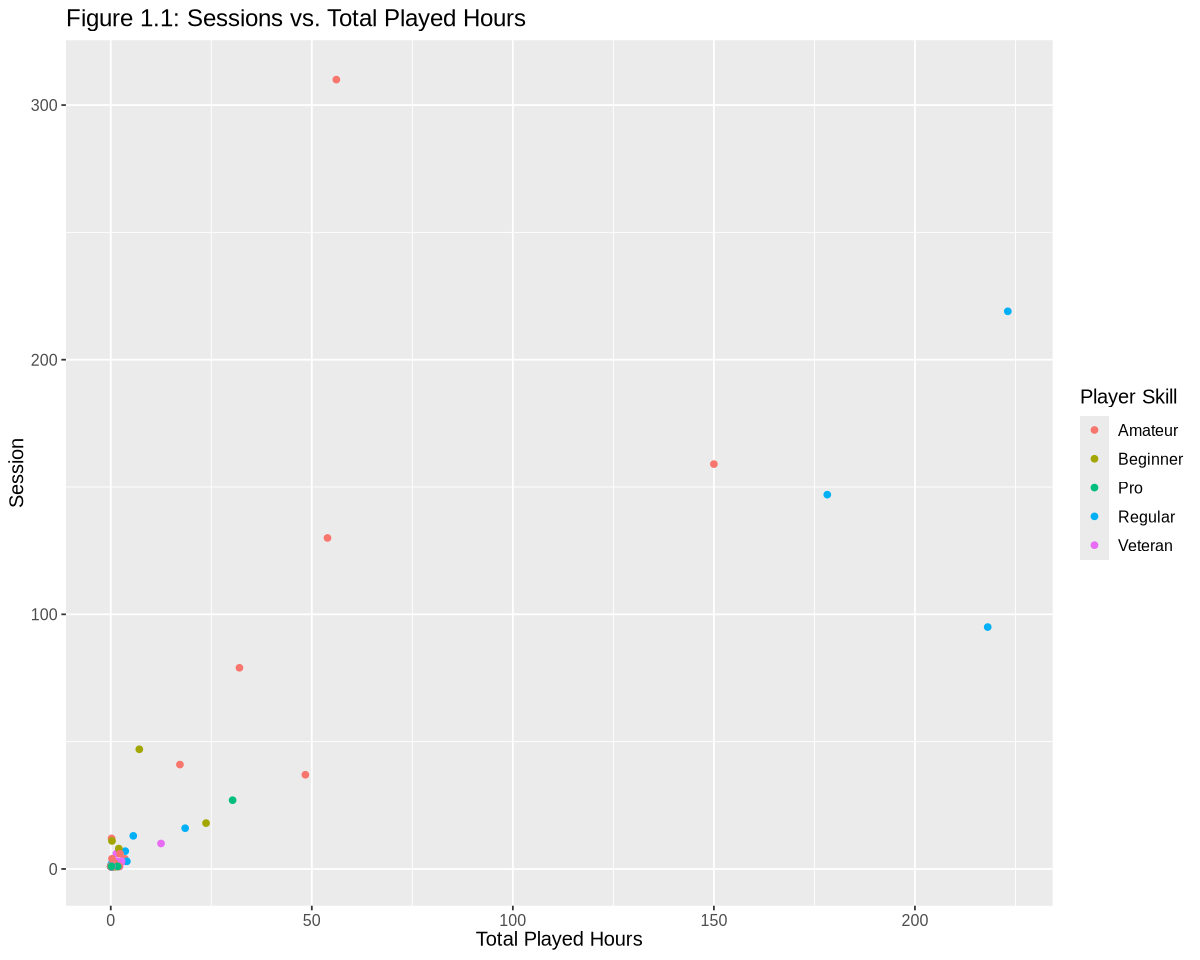

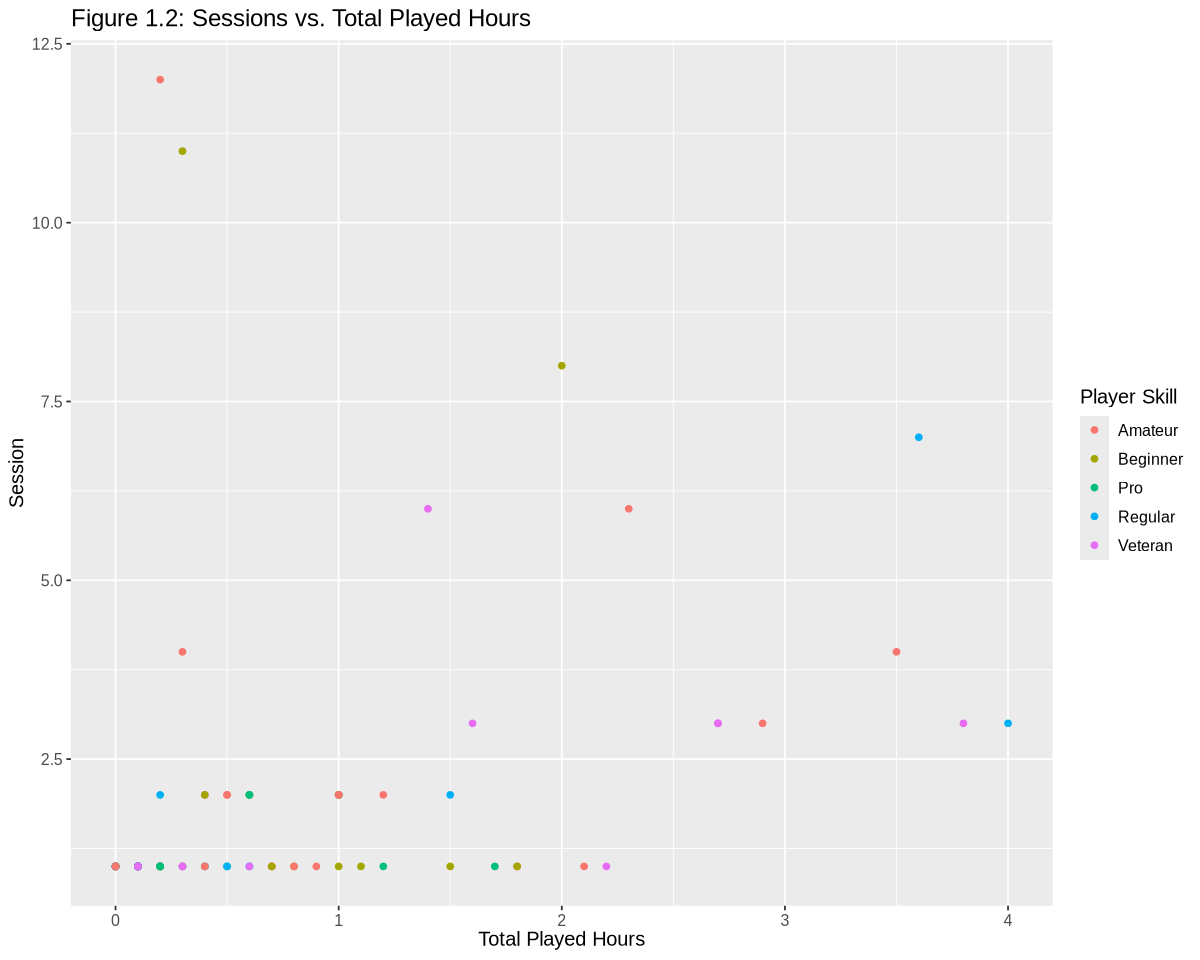

In [34]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(combined_data, aes(x = played_hours, y = sessions, color = experience)) +
geom_point() +
labs(x = "Total Played Hours", y = "Session", color = "Player Skill") +
ggtitle("Figure 1.1: Sessions vs. Total Played Hours") +
theme(text = element_text(size = 12))

players_filtered <- combined_data |>
filter(played_hours < 5) |>
filter(sessions < 50)

ggplot(players_filtered, aes(x = played_hours, y = sessions, color = experience)) +
geom_point() +
labs(x = "Total Played Hours", y = "Session", color = "Player Skill") +
ggtitle("Figure 1.2: Sessions vs. Total Played Hours") +
theme(text = element_text(size = 12))

The scatterplots in Figure 1.1 and Figure 1.2 supports this idea since there does not seem to be any patterns in player experience until players with over 50 played hours are compared (Where there are mostly Amateurs and Regulars). This shows that other predictors or methods may need to be used in determining the most active players especially when looking at players with under 50 hours of total playtime.

### Model Number 2: Exploring correlation between experience and played_hours without 0-hour players

In order to explore what the mode would look like without checking users who have not played, this model includes 
only observations in which played_hours is **bigger than 0**.

Since the goal is to predict a qualitative variable (experience), **k-nn classification** is the best method. 
We perform the standard 75% splitting and 5 fold cross-validation with tuning for best k-values ranging from 1 to 10. Also, to make sure all variables will contribute equally to the model, we will scale them in the recipe. 



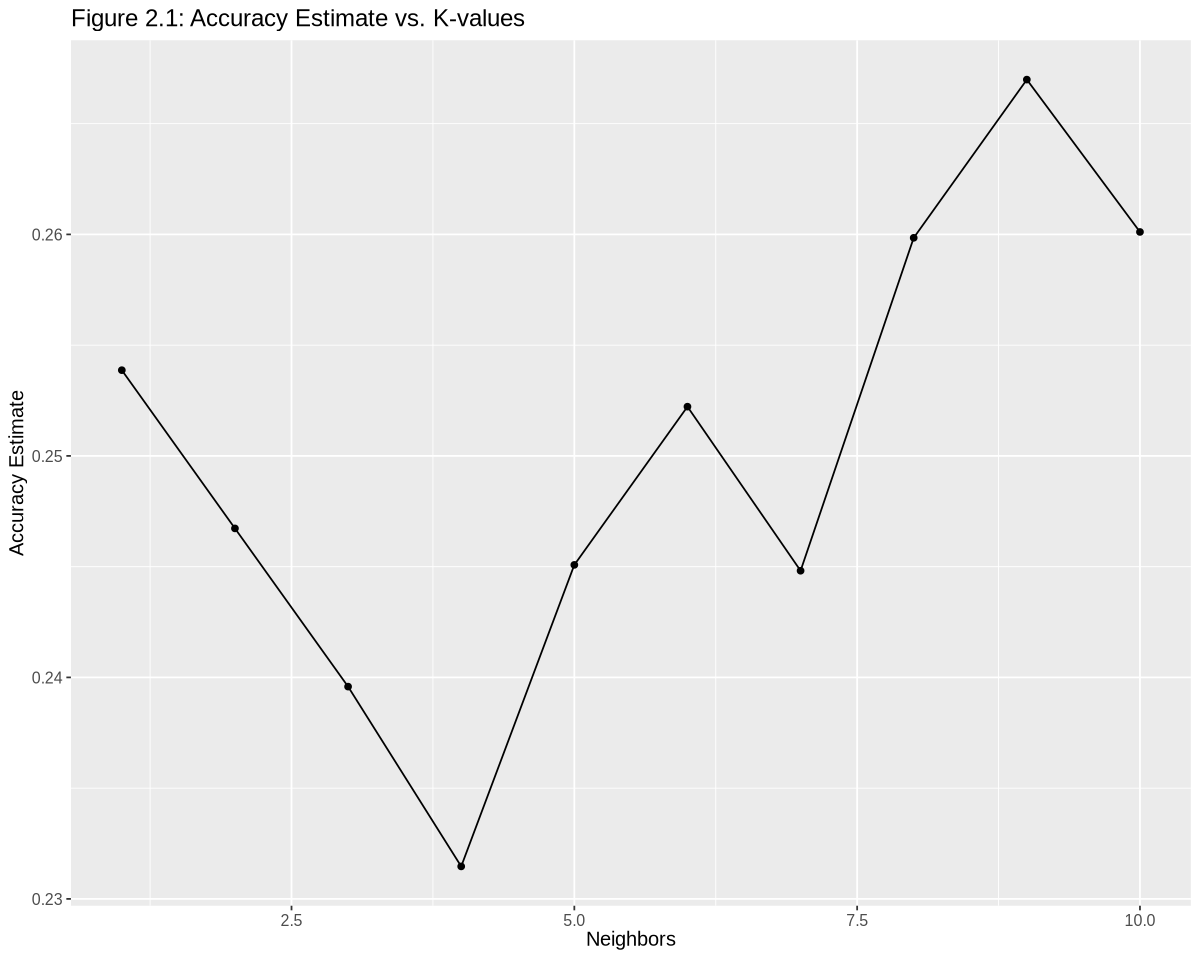

In [32]:
set.seed(2019)

players_split <- initial_split(combined_data, prop = 3/4, strata = experience)
players_train <- training(players_split)   
players_test <- testing(players_split)

players_recipe <- recipe(experience ~ played_hours , data = players_train) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = experience) # 5 fold cross-validation 

k_vals2 <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |> 
       add_recipe(players_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals2) |>
       collect_metrics()

accuracies <- knn_results |> 
              filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Figure 2.1: Accuracy Estimate vs. K-values") +
theme(text = element_text(size = 12))
accuracy_versus_k

As plotted in figure 2.1, the best k-value seems to be 8. We then proceed with fitting it:

In [8]:
best_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |> 
       add_recipe(players_recipe) |>
       add_model(best_knn) |>
fit(data = players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.7172414
Best kernel: rectangular
Best k: 8

We will now feed the model the testing set and measure accuracy:

In [35]:
played_hours_predictions <- predict(players_fit , players_test) |>
       bind_cols(players_test) |>
mutate(experience = as.factor(experience))

model_1_accuracy <- played_hours_predictions |>
        metrics(truth = experience, estimate = .pred_class)
model_1_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.31372549
kap,multiclass,-0.01190476


Therefore, the accuracy of model is 31%. While this model was slightly more accurate than the previous one,
it appears that player experience has little correlation with played hours, and is not an accurate 
predictor on its own.

### Model Number 3: Using new variable `contributor_type` as response variable

**New variable: `contributor_type`**

To create our final model, we created a new category to decide which players should be designated as “good” or “bad” contributors. The factor variable `contributor_type` was added to assign a binary label to each player, classifying them as either a good contributor or a bad contributor based on their number of hours played (the `played_hours` variable). The code for this step was mostly taken from “3.5 Convert numeric to binary” in An Introduction to R for Research by Nahhas.

Based on the distribution of hours played among all contributors (Figure 3.1), the final labels were:
- `good` – players with 1 hour or more of gameplay, considered “good” contributors,
- `bad` – players with under 1 hour of gameplay, considered “bad” contributors.

The determining number of hours played (1 hour) was chosen to allow an appropriately broad selection of players by taking into account the distribution of played hours amongst all contributors. A significant portion of players had little to no hours (Figure 3.1), which made the value of their contribution quite minimal, and as seen in the previous models, seemed to have a negative impact on our predictions. On the other hand, we did not choose a number of hours much larger than 1 since then very few players would actually be considered good contributors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


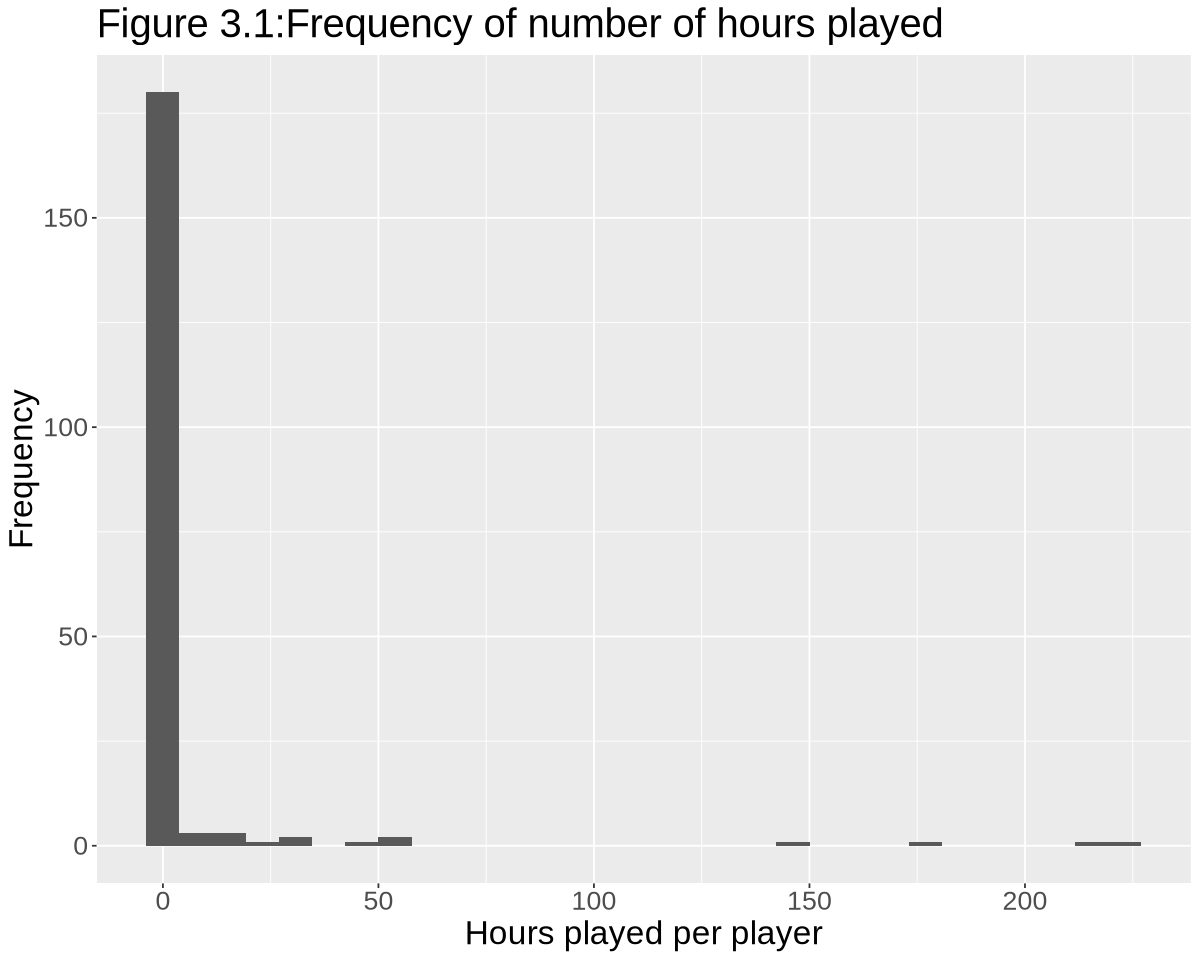

In [25]:
hours_histogram <- ggplot(players_data, aes(played_hours)) + 
geom_histogram() + 
labs(x = "Hours played per player", y = "Frequency", title = "Figure 3.1:Frequency of number of hours played") +
theme(text = element_text(size = 20))
hours_histogram

In [37]:
# Assigning labels: Good (1h+ played) vs Bad (<1h played) contributor

# As a 0/1 variable
clean_data$over1 <- as.numeric(clean_data$played_hours >= 1)

# Examine new variable
table(clean_data$over1, useNA = "ifany")


# Check range of original variable at levels of new
tapply(clean_data$played_hours, clean_data$over1, range)



# As a factor
clean_data$over1_fac <- factor(clean_data$over1,
                            levels = 0:1,
                            labels = c("<1h", ">1h"))

# Examine new variable
table(clean_data$over1_fac, useNA = "ifany")


# Check range of original variable at levels of new
tapply(clean_data$played_hours, clean_data$over1_fac, range)


#Final wrangling of the data!
labelled_data <- clean_data |>
    select(-over1) |>
    mutate(contributor_type = fct_recode(over1_fac, "Bad" = "<1h", "Good" = ">1h")) |>
    select(-over1_fac) |>
    mutate(sessions = if_else(is.na(sessions), 0, sessions)) #Changing sessions "NA" to 0 sessions
labelled_data


  0   1 
152  42 

$`0`
[1] 0.0 0.9

$`1`
[1]   1.0 223.1


<1h >1h 
152  42 

$`<1h`
[1] 0.0 0.9

$`>1h`
[1]   1.0 223.1

experience,subscribe,hashedEmail,played_hours,name,gender,age,sessions,contributor_type
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,Good
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,Good
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,Bad
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,Bad
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,Bad
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,0,Bad
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,0,Bad
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1,Bad
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1,Bad


This factor variable makes for an adequate target variable for a classification model that would predict whether a player would contribute good amounts of data or not straight away; which directly answers/targets our question.

**Building the final model with `contributor_type` as the response variable**

First, to train the model, the data was split into `training_data` (75% of observations) and `testing_data` (25% of observations) with the strata set to `contributor_type` to have a relatively proportional amount of both in the split.

In [38]:
#splitting the data

set.seed(3456)
data_split <- initial_split(labelled_data, prop = 0.75, strata = experience)
training_data <- training(data_split)
testing_data <- testing(data_split)

Finally, a k-nn classification model was built with this `contributor_type` variable as the qualitative response variable. All variables in our processed dataset (`labelled_data`) were used as predictors except for `hashedEmail` and `name` since they are simply identifier for individual players and offered no contribution to the predictive model, and `played_hours` since this variable already corresponds to the predicted `contributor_type` variable so it would only boost accuracy and hence give an unrepresentative representation of the model.

In [39]:
# Creating the basic model

classification_recipe <- recipe(contributor_type ~ subscribe + age + sessions + gender, 
                          data = training_data) |>
    step_scale(age, sessions) |>
    step_center(age, sessions)

classification_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
			set_engine("kknn") |>
			set_mode("classification")

To tune for the optimal k-value, a five fold cross-validation was performed for k-values ranging from 1 to 10 (Figure 3.2).

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7630542,5,0.04306050,Preprocessor1_Model01
2,accuracy,binary,0.7633005,5,0.04101632,Preprocessor1_Model02
3,accuracy,binary,0.7773399,5,0.03463723,Preprocessor1_Model03
4,accuracy,binary,0.7842365,5,0.03261664,Preprocessor1_Model04
5,accuracy,binary,0.8330049,5,0.02090551,Preprocessor1_Model05
6,accuracy,binary,0.8330049,5,0.02090551,Preprocessor1_Model06
7,accuracy,binary,0.8332512,5,0.01312371,Preprocessor1_Model07
8,accuracy,binary,0.8332512,5,0.01312371,Preprocessor1_Model08
9,accuracy,binary,0.8332512,5,0.01312371,Preprocessor1_Model09


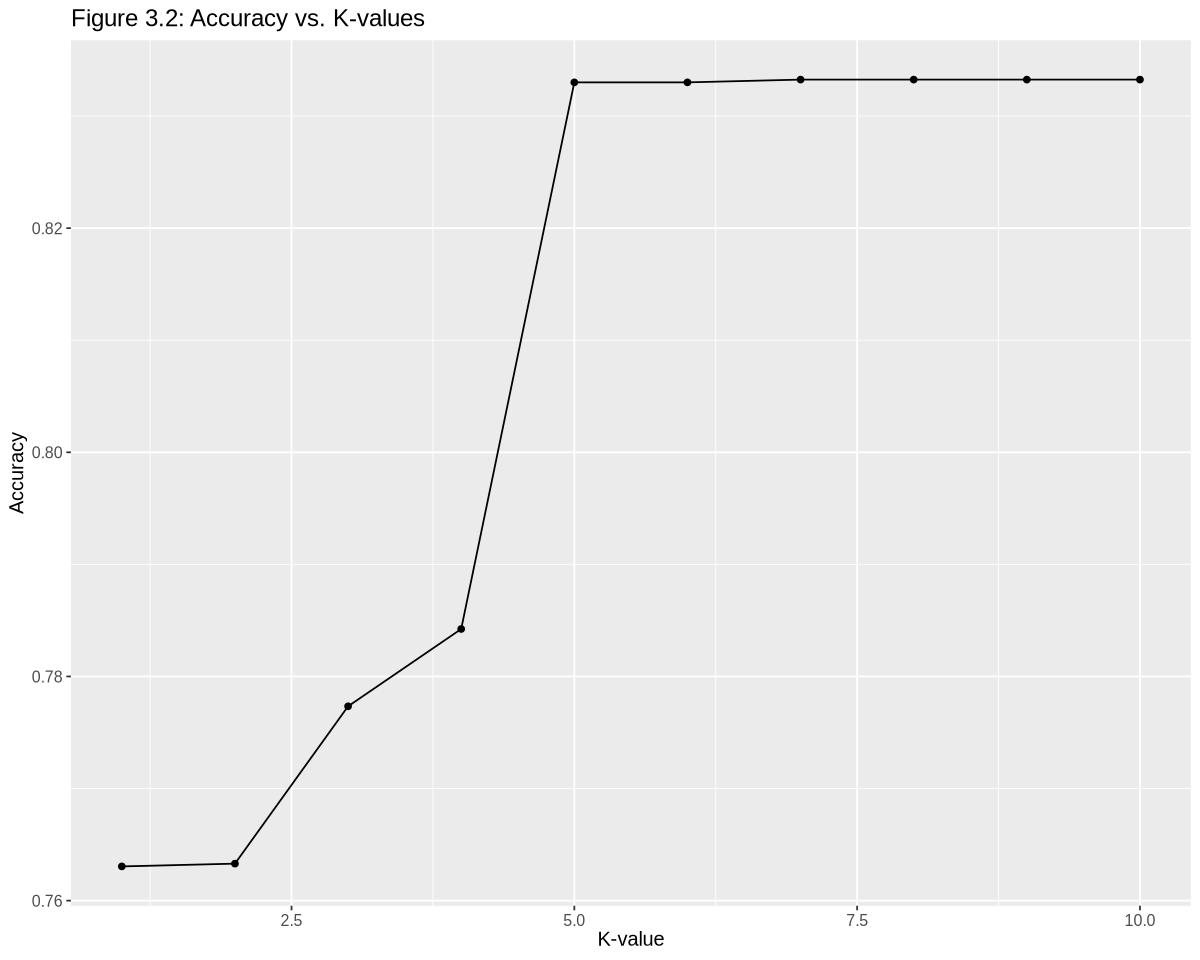

In [30]:
# Creating the model with tuning and cross-validation: Choosing the optimal k-value

set.seed(3456)

data_vfold <- vfold_cv(training_data, v = 5, strata = contributor_type)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))


metrics <- workflow() |>
        add_recipe(classification_recipe) |>
        add_model(classification_knn) |>
        tune_grid(resamples = data_vfold, grid = k_vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy")
metrics


cross_val_plot <- ggplot(metrics, aes(x= neighbors, y= mean)) +
    geom_point() +
    geom_line() +
    labs(x= "K-value", y= "Accuracy") +
    ggtitle("Figure 3.2: Accuracy vs. K-values") +
    theme(text = element_text(size = 12))
cross_val_plot

As shown in figure 3.2, the accuracy by k-value plot yielded k = 5 as an appropriate choice.

The final tuning of the model with k = 5 and fitting to the `testing_data`, the accuracy of this model was found to be 78%.

In [23]:
# Building the tuned model with k = 5

tuned_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
			set_engine("kknn") |>
			set_mode("classification")

tuned_fit <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(tuned_knn) |>
    fit(data = training_data)
#tuned_fit

predictions <- predict(tuned_fit, testing_data) |>
    bind_cols(testing_data)
#predictions

tuned_accuracy <- predictions |>
        metrics(truth = contributor_type, estimate = .pred_class) |>
        filter(.metric == "accuracy")
tuned_accuracy 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8


### Overview of “good” contributors

Based on the classification under `contributor_type`, some more visualizations were made to create an overview of the general characteristics of “good” contributors. Based on these visualizations, we can compile some general characteristics of typical “good” contributors. 

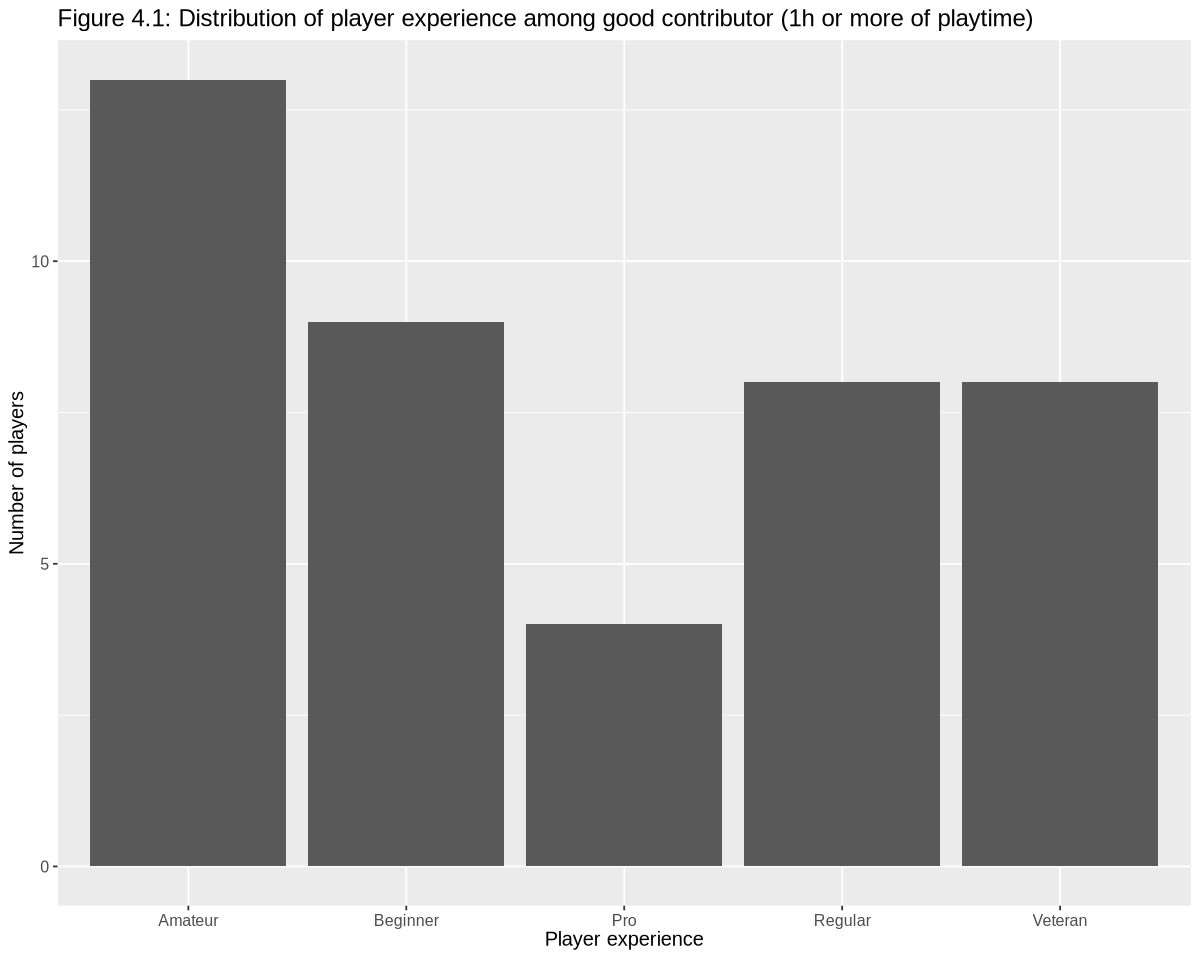

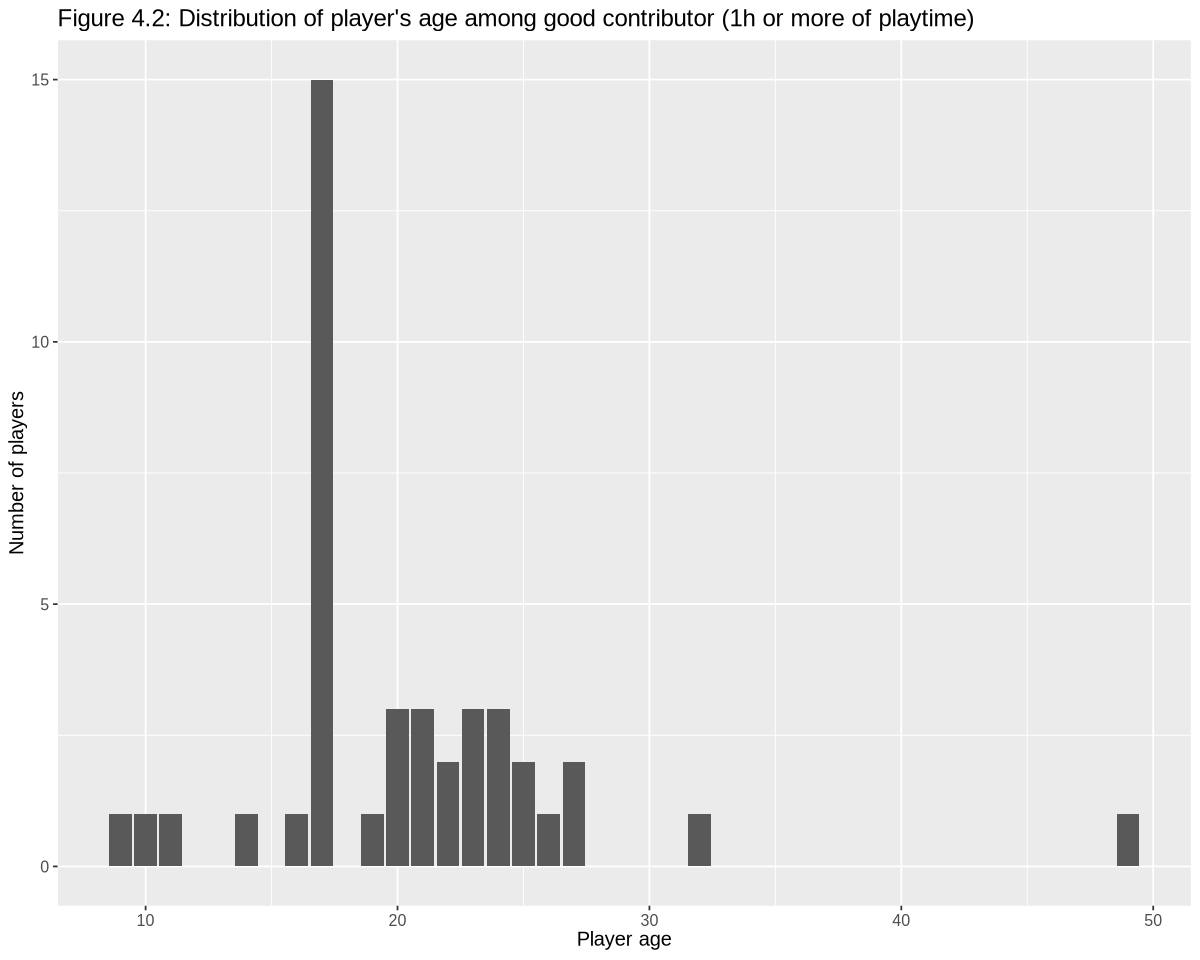

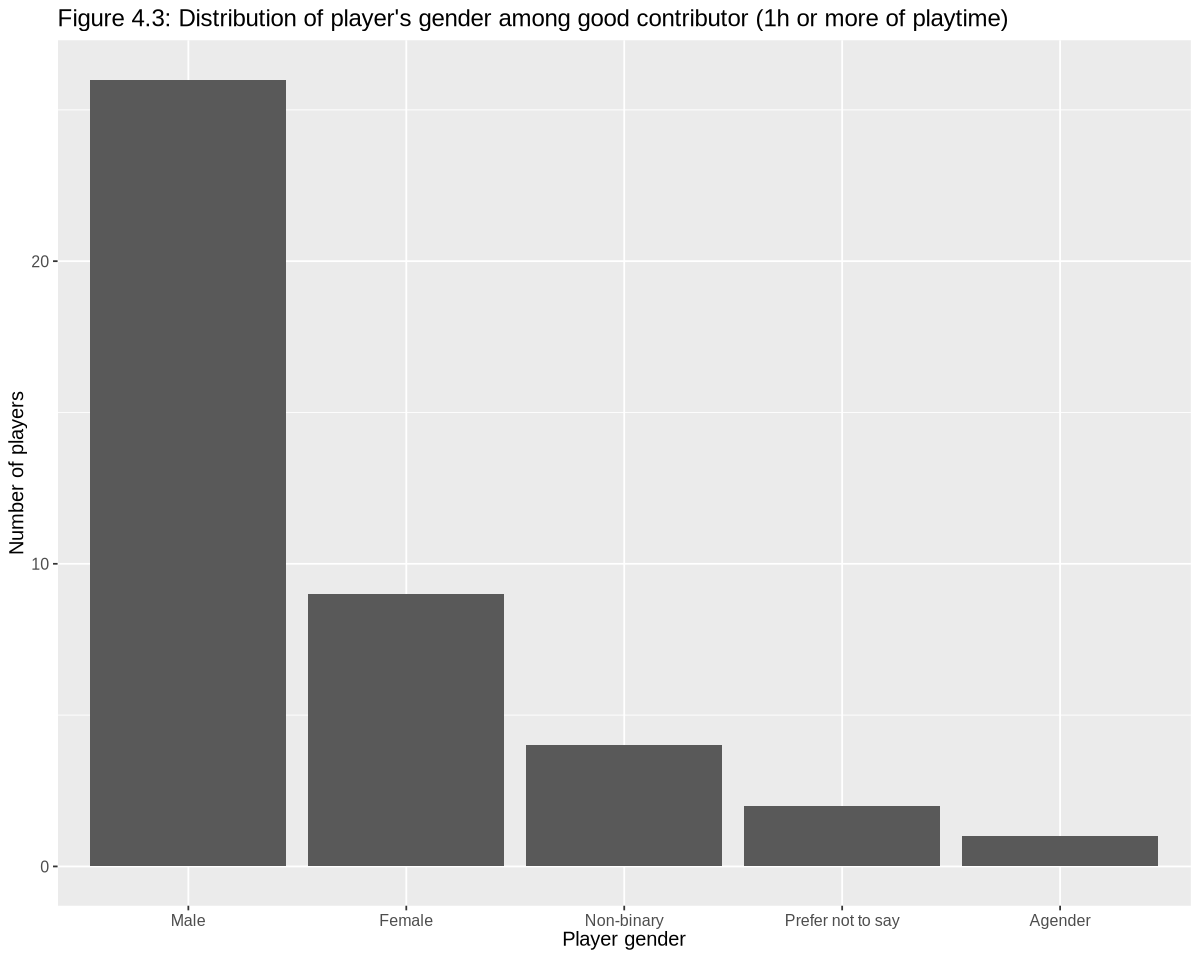

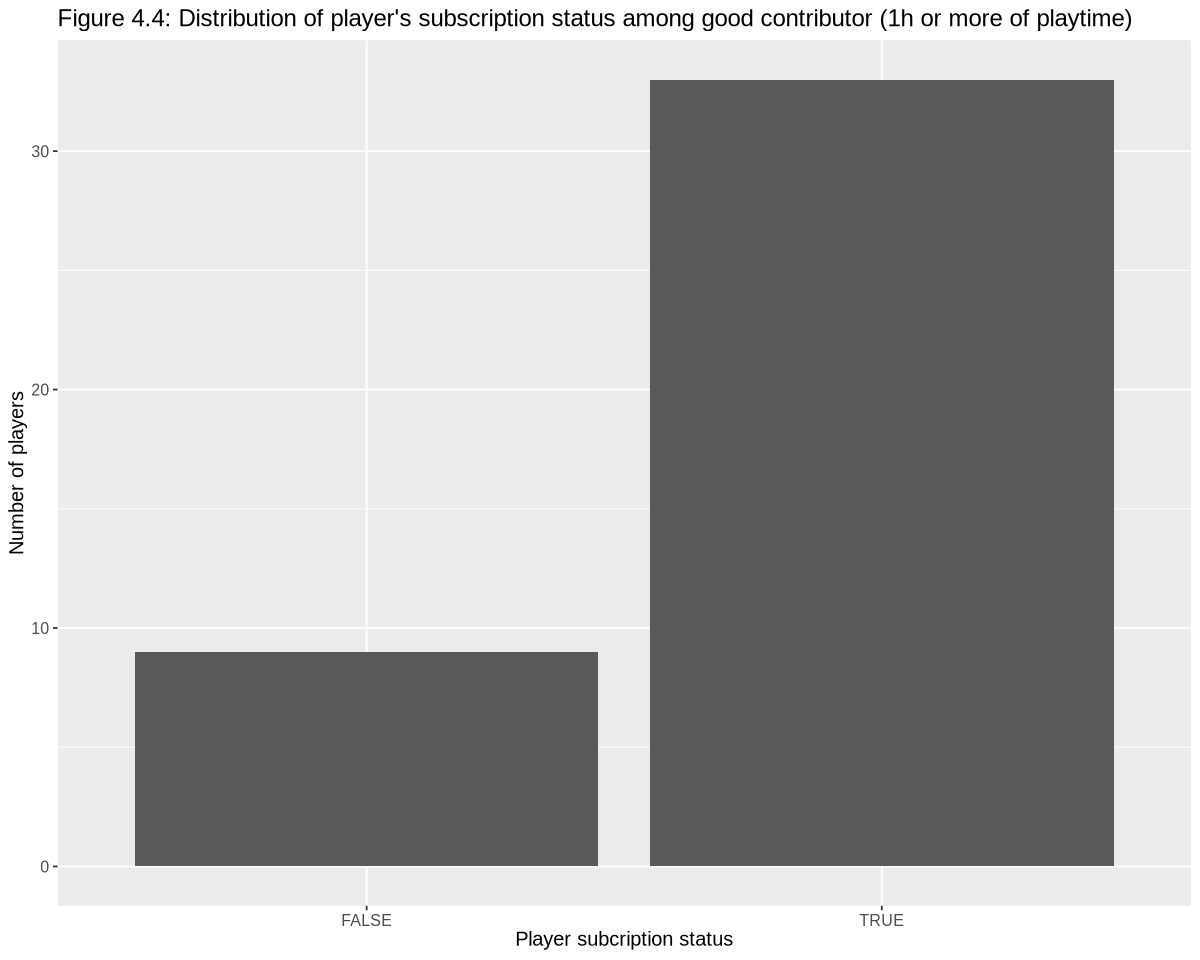

In [42]:
# Visualizations exploring the characteristics of "good" contributors

good_contributors <- labelled_data |>
    filter(contributor_type == "Good")
#good_contributors


# 1. EXPERIENCE

goodcontributors_experience <- good_contributors |>
    group_by(experience) |>
    count()
#goodcontributors_experience

experience_plot <- goodcontributors_experience |>
    ggplot(aes(x= experience, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player experience", y= "Number of players", title= "Figure 4.1: Distribution of player experience among good contributor (1h or more of playtime)") +
    theme(text = element_text(size = 12))
experience_plot


# 2. age

goodcontributors_age <- good_contributors |>
    group_by(age) |>
    count()
#goodcontributors_age

age_plot <- goodcontributors_age |>
    ggplot(aes(x= age, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player age", y= "Number of players", title= "Figure 4.2: Distribution of player's age among good contributor (1h or more of playtime)") +
    theme(text = element_text(size = 12))
age_plot


# 3. GENDER

goodcontributors_gender <- good_contributors |>
    group_by(gender) |>
    count()
#goodcontributors_gender

gender_plot <- goodcontributors_gender |>
    ggplot(aes(x= gender, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player gender", y= "Number of players", title= "Figure 4.3: Distribution of player's gender among good contributor (1h or more of playtime)") +
    theme(text = element_text(size = 12))
gender_plot


# 4. SUBSCRIBE

goodcontributors_sub <- good_contributors |>
    group_by(subscribe) |>
    count()
#goodcontributors_sub

sub_plot <- goodcontributors_sub |>
    ggplot(aes(x= subscribe, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player subcription status", y= "Number of players", title= "Figure 4.4: Distribution of player's subscription status among good contributor (1h or more of playtime)") +
    theme(text = element_text(size = 12))
sub_plot

## Discussion

### Summary of result

**The prototype “good contributor”**

Based on the above visualizations [Figure 4.1 - 4.4], we were able to create a prototype “good contributor” based on the most common characteristics within each predictor in our data. 

Most players labeled as “good” contributors: 
- self-reported their experience as `Amateur`,
- were around their late teens.
- self-reported as male
- subscribed to PLAIcraft email updates.

By creating a prototype good contributor, we have essentially outlined a possible demographic of players for PLAI researchers to focus on in their future recruitment efforts for data collection. Advertisement efforts could be focused to cater towards players fitting the experience, age and gender characteristics, while subscription to email updates could be encouraged in order to hopefully acquire more data from contributors.

**Other trends/tendencies among “good” contributors compared to all contributors**

However, there were some statistics which, while not dominant, were more common among the players labelled as “good” contributors:

See below the "good contributors" dataset's experience rates:

In [19]:
good_contributors_experience <- good_contributors |>
group_by(experience) |>
summarize(count = n()) |>
mutate(percentage = (count/42)*100)
good_contributors_experience

experience,count,percentage
<chr>,<int>,<dbl>
Amateur,13,30.95238
Beginner,9,21.42857
Pro,4,9.52381
Regular,8,19.04762
Veteran,8,19.04762


Compared to the regular dataset:

In [20]:
default_experience_stats <- players_data |>
group_by(experience) |>
summarize(count = n()) |>
mutate(percent = (count / 196) * 100) 
default_experience_stats 

experience,count,percent
<chr>,<int>,<dbl>
Amateur,63,32.142857
Beginner,35,17.857143
Pro,14,7.142857
Regular,36,18.367347
Veteran,48,24.489796


- Beginners were 5% *more* common among the good contributor group. Veterans were significantly *less* common, making up 5% *less* of the dataset.

- Similarly, comparing the "good contributors" subscribe rates (first table) with the default ones shows they are roughly 5% more likely to subscribe.


In [21]:
gc_subscribe <- good_contributors |>
group_by(subscribe) |>
summarize(count = n()) |>
mutate(percentage = (count/42)*100)

gc_subscribe

default_sub_stats <- players_data |>
group_by(subscribe) |>
summarize(count = n()) |>
mutate(percent = (count/196)*100)

default_sub_stats

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,9,21.42857
TRUE,33,78.57143


subscribe,count,percent
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


- While still making up a minority of the dataset, female and nonbinary players were slightly more common among the “good” contributor group, at 3% and 2% more respectively. 

In [22]:
gc_gender <- good_contributors |>
group_by(gender) |>
summarize(count = n()) |>
mutate(percentage = (count/42)*100)

gc_gender

default_gender_stats <- players_data |>
group_by(gender) |>
summarize(count = n()) |>
mutate(percent = (count/196)*100)

default_gender_stats

gender,count,percentage
<fct>,<int>,<dbl>
Male,26,61.904762
Female,9,21.428571
Non-binary,4,9.523810
Prefer not to say,2,4.761905
Agender,1,2.380952


gender,count,percent
<chr>,<int>,<dbl>
Agender,2,1.0204082
Female,37,18.8775510
Male,124,63.2653061
Non-binary,15,7.6530612
Other,1,0.5102041
Prefer not to say,11,5.6122449
Two-Spirited,6,3.0612245


### Our expectations vs. results

Overall, we found that while we expected more experienced players to be more active on the server, experience had little correlation with played hours, and contribution value by consequence.
Possible issues and further possibilities

Another issue we found in analyzing the dataset is that there were not enough data points for rarer categories such as pros which may have amplified the role luck (or seed) played in the model’s accuracy.

Usage of the `sessions` dataset
In our final model, the player’s number of sessions (`sessions`) was used as a predictor. However, there is a fairly direct relationship between the number of sessions and the number of played hours, which could make the use of `sessions` as a predictor inadequate for the same reason why we removed `played_hours` as a predictor for the final classification model.


## References

Nahhas, Ramzi W. “3.5 Convert numeric to binary.” An Introduction to R for Research. E-book, Bookdown, 2024. bookdown.org/rwnahhas/IntroToR/. Accessed Dec 1st 2024.

“PLAIcraft.” PLAICraft, Pacific Laboratory of Artificial Intelligence, 2023, plaicraft.ai/.
